In [5]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Aug-2022/train.csv'
file_key_2 = 'Tabular-Playground-Aug-2022/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train = train.drop(columns = ['id'], axis = 1)

test = pd.read_csv(file_content_stream_2)
test = test.drop(columns = ['id'], axis = 1)

## Changing labels to dummies
train_dummies = pd.get_dummies(train[['attribute_0']])
train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
train = pd.concat([train, train_dummies], axis = 1)

test_dummies = pd.get_dummies(test[['attribute_0']])
test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

## Filling missing values with kNN
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
train = pd.DataFrame(knn_imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(knn_imputer.fit_transform(test), columns = test.columns)

## Engineering features
train['feature_1'] = np.where(train['loading'] < 150, 0, 1)
test['feature_1'] = np.where(test['loading'] < 150, 0, 1)

## Defining input and target variables
X = train[['loading', 'measurement_2', 'measurement_4', 'measurement_5',
           'measurement_6', 'measurement_7', 'measurement_8', 'measurement_15',
           'measurement_17', 'feature_1']]
# X = train.drop(columns = ['failure'], axis = 1)
Y = train['failure']

In [14]:
X.describe()

,loading,measurement_2,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_15,measurement_17,feature_1
count,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000
mean,127.824257,6.256568,11.732543,17.127679,17.510323,11.718744,19.023678,14.997997,701.478076,0.242680
std,38.878297,3.309109,0.988002,0.985980,0.983746,0.986485,0.992268,1.501759,119.001345,0.428711
min,33.160000,0.000000,8.008000,12.073000,12.715000,7.968000,15.217000,9.104000,196.787000,0.000000
25%,100.200000,4.000000,11.068000,16.461000,16.859000,11.069000,18.366000,14.014250,625.263500,0.000000
50%,122.460000,6.000000,11.733000,17.130000,17.515000,11.717000,19.017000,14.979310,701.683500,0.000000
75%,148.957500,8.000000,12.400000,17.789000,18.162000,12.374000,19.686000,15.951000,777.661100,0.000000
max,385.860000,24.000000,16.484000,21.425000,21.543000,15.419000,23.807000,21.626000,1312.794000,1.000000


In [12]:
## Building Random Forest model
RF_md = RandomForestClassifier(n_estimators = 300, max_depth = 3, criterion = 'gini').fit(X, Y)

In [13]:
importance = pd.DataFrame({'feature': X.columns, 'Imp': RF_md.feature_importances_})
importance = importance.sort_values(by = 'Imp', ascending = False)
importance

,feature,Imp
0,loading,0.477485
9,feature_1,0.296011
8,measurement_17,0.061177
3,measurement_5,0.037333
4,measurement_6,0.030251
7,measurement_15,0.021286
6,measurement_8,0.020927
1,measurement_2,0.018895
5,measurement_7,0.018398
2,measurement_4,0.018238


In [35]:
from sklearn.feature_selection import RFECV

## Running RFE with Random forest
RF_auto_feature = RFECV(estimator = RandomForestClassifier(n_estimators = 300, max_depth = 3), step = 1, scoring = 'roc_auc', min_features_to_select = 10, cv = 3, n_jobs = -1).fit(X, Y)

## Appending results 
X.columns[RF_auto_feature.support_]

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


Index(['loading', 'measurement_2', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_15',
       'measurement_17', 'feature_1'],
      dtype='object')

In [34]:
X.columns[RF_auto_feature.support_]

Index(['loading', 'measurement_5', 'measurement_6', 'measurement_17',
       'feature_1'],
      dtype='object')

In [22]:
X.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7
count,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.00000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000
mean,127.829212,6.754046,7.240459,7.415883,8.232518,6.256568,17.790569,11.732569,17.127555,17.510380,11.718814,19.023913,11.429244,16.121777,19.174885,11.701254,15.64807,16.039238,14.998065,16.456881,701.468679,0.197591,0.802409
std,38.880538,1.471852,1.456493,4.116690,4.199401,3.309109,0.995588,0.988010,0.985960,0.983739,0.986499,0.992293,0.980788,1.379475,1.487117,1.452606,1.12379,1.451756,1.501788,1.651711,119.014296,0.398190,0.398190
min,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,7.968000,15.217000,7.537000,9.323000,12.461000,5.167000,10.89000,9.140000,9.104000,9.701000,196.787000,0.000000,0.000000
25%,100.200000,6.000000,6.000000,4.000000,5.000000,4.000000,17.122540,11.067250,16.461000,16.859000,11.069000,18.367000,10.781000,15.239000,18.217000,10.755000,14.93100,15.102000,14.015000,15.345250,625.211500,0.000000,1.000000
50%,122.465000,6.000000,8.000000,7.000000,8.000000,6.000000,17.784500,11.733000,17.130000,17.515000,11.717000,19.016500,11.427000,16.134000,19.212887,11.709830,15.62100,16.022000,14.980000,16.431500,701.784000,0.000000,1.000000
75%,148.980000,8.000000,8.000000,10.000000,11.000000,8.000000,18.460000,12.400000,17.789000,18.162000,12.374000,19.686110,12.076000,16.999000,20.167000,12.663000,16.32600,17.016750,15.950000,17.536000,777.628000,0.000000,1.000000
max,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,15.419000,23.807000,15.412000,22.479000,25.640000,17.663000,22.71300,22.303000,21.626000,24.094000,1312.794000,1.000000,1.000000


In [23]:
test.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
count,20552.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20446.000000,20366.000000,20267.000000,20151.000000,20055.000000,19929.000000,19871.000000,19708.000000,19639.000000,19535.000000,19472.000000,19335.000000,19233.000000,19097.000000,19035.000000
mean,127.634895,7.733959,6.196823,7.453574,8.962407,6.126931,17.793466,11.727331,17.138080,17.515797,11.710919,19.030765,11.417921,16.123986,18.846571,11.914230,15.736104,16.123958,15.115915,16.636052,701.389816
std,39.154642,1.308535,1.917478,4.274477,4.334200,3.835881,1.002206,1.006834,1.008714,1.000067,1.001096,1.005401,0.999953,1.565414,1.588642,1.363253,1.357019,1.410569,1.545069,1.643463,130.205829
min,37.700000,6.000000,4.000000,0.000000,0.000000,0.000000,13.565000,7.384000,12.215000,13.539000,7.853000,14.885000,7.578000,9.167000,13.127000,6.116000,9.209000,8.415000,8.417000,10.162000,1.671000
25%,99.470000,6.000000,4.000000,4.000000,6.000000,3.000000,17.119000,11.048250,16.457000,16.847000,11.035000,18.351000,10.744000,15.095000,17.714000,11.069000,14.871000,15.238000,14.082000,15.512000,618.723500
50%,122.110000,7.000000,5.000000,7.000000,9.000000,6.000000,17.789000,11.729000,17.132000,17.510000,11.704000,19.040000,11.414000,16.109500,18.810000,11.941000,15.734000,16.119000,15.062000,16.706000,701.379000
75%,148.840000,9.000000,7.000000,10.000000,12.000000,8.000000,18.478000,12.411000,17.824500,18.197000,12.385000,19.707000,12.093000,17.156000,19.967500,12.791000,16.605000,17.001500,16.107000,17.781000,784.872500
max,385.570000,9.000000,9.000000,30.000000,33.000000,28.000000,21.389000,15.623000,21.681000,21.183000,15.828000,23.092000,15.091000,23.354000,24.950000,18.962000,21.677000,23.140000,22.097000,22.270000,1242.786000


[Text(697.5, 713.475, 'loading <= 150.115\ngini = 0.335\nsamples = 26570\nvalue = [20921, 5649]'),
 Text(348.75, 509.625, 'loading <= 98.605\ngini = 0.304\nsamples = 20137\nvalue = [16365, 3772]'),
 Text(174.375, 305.775, 'measurement_17 <= 691.186\ngini = 0.254\nsamples = 6218\nvalue = [5291, 927]'),
 Text(87.1875, 101.92499999999995, 'gini = 0.221\nsamples = 2875\nvalue = [2512, 363]'),
 Text(261.5625, 101.92499999999995, 'gini = 0.28\nsamples = 3343\nvalue = [2779, 564]'),
 Text(523.125, 305.775, 'loading <= 128.265\ngini = 0.325\nsamples = 13919\nvalue = [11074, 2845]'),
 Text(435.9375, 101.92499999999995, 'gini = 0.309\nsamples = 8723\nvalue = [7060, 1663]'),
 Text(610.3125, 101.92499999999995, 'gini = 0.351\nsamples = 5196\nvalue = [4014, 1182]'),
 Text(1046.25, 509.625, 'loading <= 253.485\ngini = 0.413\nsamples = 6433\nvalue = [4556, 1877]'),
 Text(871.875, 305.775, 'measurement_6 <= 16.21\ngini = 0.409\nsamples = 6224\nvalue = [4439, 1785]'),
 Text(784.6875, 101.92499999999995

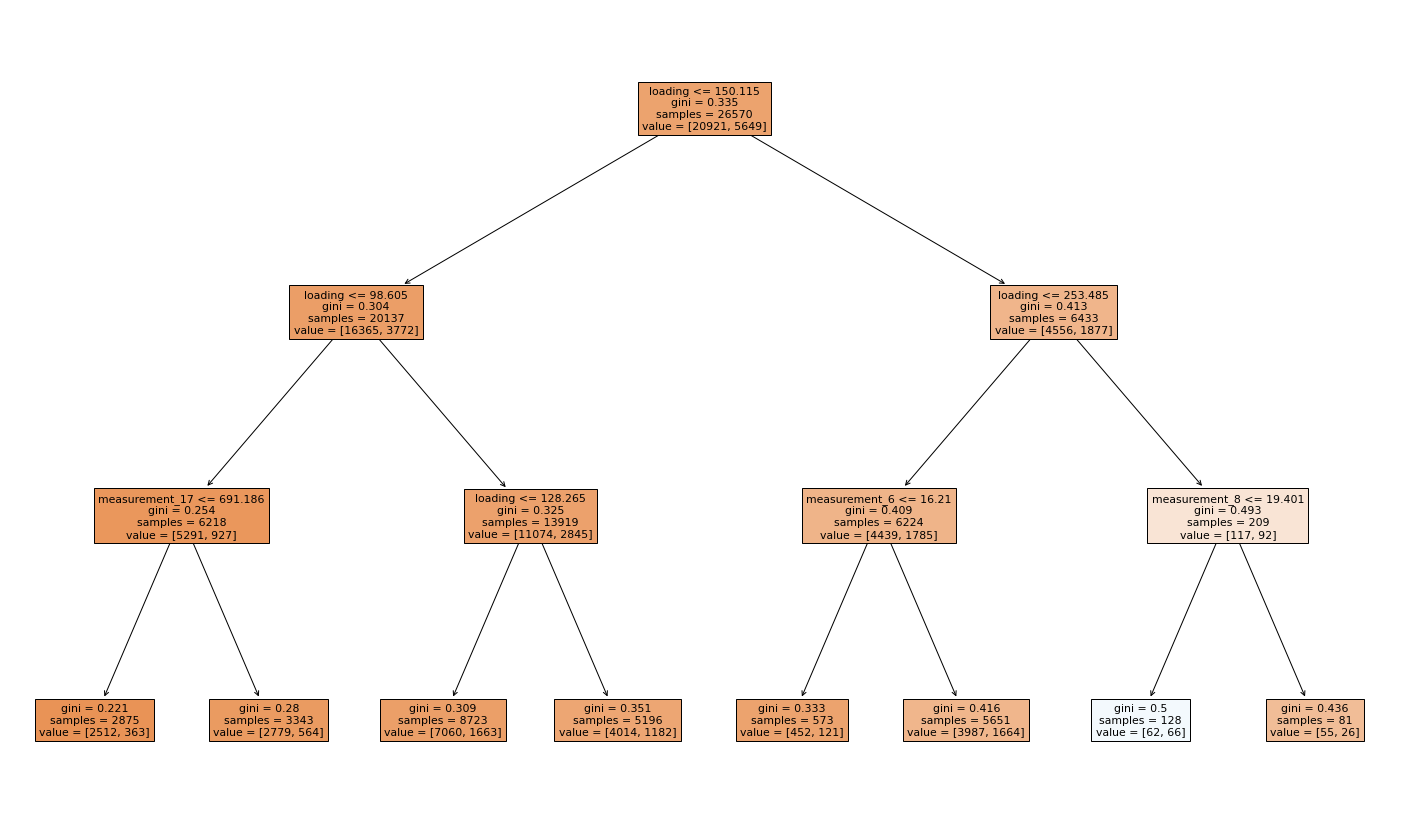

In [20]:
## Building the decision tree on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X.columns, filled = True)

<AxesSubplot:xlabel='failure', ylabel='measurement_3'>

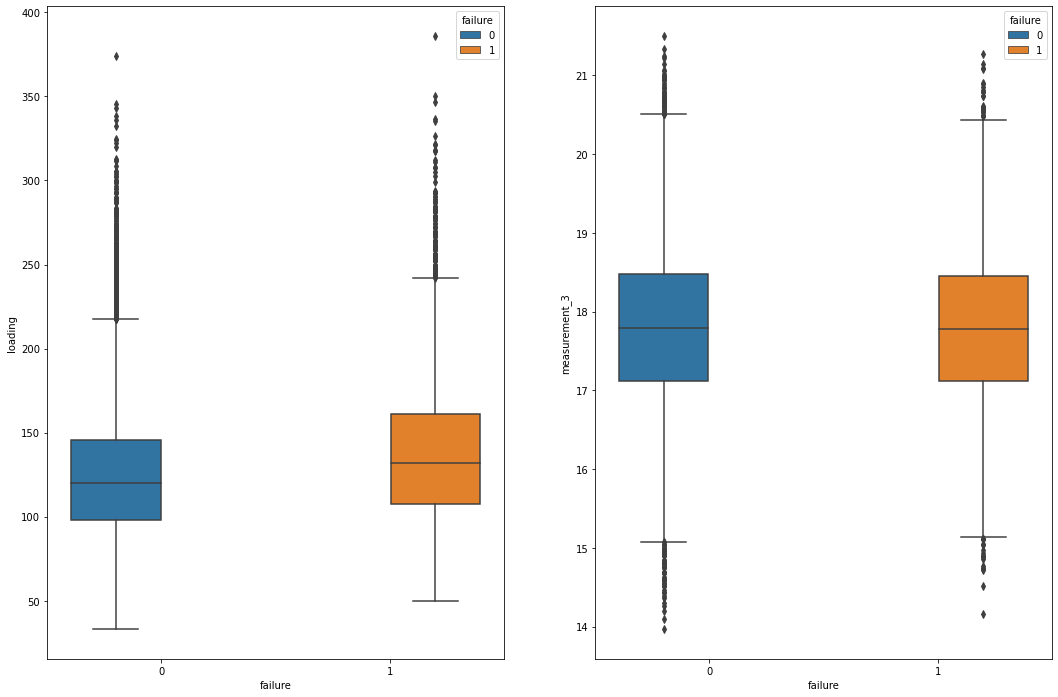

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (18, 12))

sns.boxplot(ax = axes[0], x = 'failure', y = 'loading', hue = 'failure', data = train)
sns.boxplot(ax = axes[1], x = 'failure', y = 'measurement_3', hue = 'failure', data = train)

In [6]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [4]:
train['attribute_1'].value_counts()

material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64

In [5]:
test['attribute_1'].value_counts()

material_6    10529
material_5     5228
material_7     5018
Name: attribute_1, dtype: int64

In [17]:
test.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7
0,119.57,6.0,4.0,6.0,9.0,6.0,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.0700,13.772,13.659,16.825,13.742,17.710,634.612,1.0,0.0
1,113.51,6.0,4.0,11.0,8.0,0.0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,18.1904,12.473,17.468,16.708,14.776,14.102,537.037,1.0,0.0
2,112.16,6.0,4.0,8.0,12.0,4.0,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.0860,10.907,13.363,15.737,17.065,16.021,658.995,1.0,0.0
3,112.72,6.0,4.0,8.0,11.0,10.0,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.1630,10.933,15.501,15.667,12.620,16.111,594.301,1.0,0.0
4,208.00,6.0,4.0,14.0,16.0,8.0,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.8490,11.941,16.070,16.183,13.324,17.150,801.044,1.0,0.0


In [18]:
test.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7
count,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000
mean,127.623161,7.733959,6.196823,7.453574,8.962407,6.126931,17.793284,11.729566,17.138432,17.519328,11.710157,19.031998,11.416292,16.123085,18.854114,11.913767,15.735555,16.130141,15.116247,16.629209,701.650857,0.506811,0.493189
std,38.985640,1.308535,1.917478,4.274477,4.334200,3.835881,0.995833,0.999003,0.998771,0.988476,0.986606,0.988419,0.982457,1.532689,1.554589,1.330719,1.322833,1.370807,1.500093,1.590172,125.803448,0.499966,0.499966
min,37.700000,6.000000,4.000000,0.000000,0.000000,0.000000,13.565000,7.384000,12.215000,13.539000,7.853000,14.885000,7.578000,9.167000,13.127000,6.116000,9.209000,8.415000,8.417000,10.162000,1.671000,0.000000,0.000000
25%,99.710000,6.000000,4.000000,4.000000,6.000000,3.000000,17.129000,11.061000,16.471000,16.865000,11.058000,18.376000,10.767000,15.144000,17.772500,11.106000,14.915500,15.295000,14.136000,15.583500,624.585400,0.000000,0.000000
50%,122.170000,7.000000,5.000000,7.000000,9.000000,6.000000,17.788000,11.732000,17.133000,17.518000,11.703000,19.043000,11.412400,16.110000,18.828000,11.938000,15.733000,16.136000,15.075000,16.677000,701.928000,1.000000,0.000000
75%,148.700000,9.000000,7.000000,10.000000,12.000000,8.000000,18.470000,12.404000,17.807500,18.186000,12.363000,19.682000,12.063000,17.117000,19.920000,12.752000,16.559000,16.955000,16.046800,17.703500,779.284400,1.000000,1.000000
max,385.570000,9.000000,9.000000,30.000000,33.000000,28.000000,21.389000,15.623000,21.681000,21.183000,15.828000,23.092000,15.091000,23.354000,24.950000,18.962000,21.677000,23.140000,22.097000,22.270000,1242.786000,1.000000,1.000000


In [10]:
## Defining the model 
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
X_new = knn_imputer.fit_transform(X)

In [12]:
X_new = pd.DataFrame(X_new)

In [13]:
X_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,80.10,9.0,5.0,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.5940,15.193,15.029,14.5984,13.034,14.684,764.100,0.0,1.0
1,84.89,9.0,5.0,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.9150,11.755,14.732,15.4250,14.395,15.631,682.057,0.0,1.0
2,82.43,9.0,5.0,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.1346,13.798,16.711,18.6310,14.094,17.946,663.376,0.0,1.0
3,101.07,9.0,5.0,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.3770,10.020,15.250,15.5620,16.154,17.172,826.282,0.0,1.0
4,188.06,9.0,5.0,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.9320,12.428,16.182,12.7600,13.153,16.412,579.885,0.0,1.0


In [2]:
train.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,attribute_0_material_5,attribute_0_material_7
0,80.10,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,0,1
1,84.89,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,0,1
2,82.43,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,0,1
3,101.07,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,0,1
4,188.06,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,0,1


In [3]:
train.shape

(26570, 24)

In [4]:
train.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,attribute_0_material_5,attribute_0_material_7
count,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,25633.000000,25522.000000,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000,26570.000000,26570.000000
mean,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,11.716624,19.024714,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608,0.197591,0.802409
std,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,1.000836,1.008591,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160,0.398190,0.398190
min,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,7.968000,15.217000,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000,0.000000,0.000000
25%,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,11.045000,18.340250,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000,0.000000,1.000000
50%,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,11.712000,19.021000,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000,0.000000,1.000000
75%,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,12.391000,19.708000,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000,0.000000,1.000000
max,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,15.419000,23.807000,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000,1.000000,1.000000


In [5]:
test.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7
0,119.57,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,1,0
1,113.51,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,1,0
2,112.16,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,1,0
3,112.72,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,1,0
4,208.00,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,1,0


In [6]:
test.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7
count,20552.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20446.000000,20366.000000,20267.000000,20151.000000,20055.000000,19929.000000,19871.000000,19708.000000,19639.000000,19535.000000,19472.000000,19335.000000,19233.000000,19097.000000,19035.000000,20775.000000,20775.000000
mean,127.634895,7.733959,6.196823,7.453574,8.962407,6.126931,17.793466,11.727331,17.138080,17.515797,11.710919,19.030765,11.417921,16.123986,18.846571,11.914230,15.736104,16.123958,15.115915,16.636052,701.389816,0.506811,0.493189
std,39.154642,1.308535,1.917478,4.274477,4.334200,3.835881,1.002206,1.006834,1.008714,1.000067,1.001096,1.005401,0.999953,1.565414,1.588642,1.363253,1.357019,1.410569,1.545069,1.643463,130.205829,0.499966,0.499966
min,37.700000,6.000000,4.000000,0.000000,0.000000,0.000000,13.565000,7.384000,12.215000,13.539000,7.853000,14.885000,7.578000,9.167000,13.127000,6.116000,9.209000,8.415000,8.417000,10.162000,1.671000,0.000000,0.000000
25%,99.470000,6.000000,4.000000,4.000000,6.000000,3.000000,17.119000,11.048250,16.457000,16.847000,11.035000,18.351000,10.744000,15.095000,17.714000,11.069000,14.871000,15.238000,14.082000,15.512000,618.723500,0.000000,0.000000
50%,122.110000,7.000000,5.000000,7.000000,9.000000,6.000000,17.789000,11.729000,17.132000,17.510000,11.704000,19.040000,11.414000,16.109500,18.810000,11.941000,15.734000,16.119000,15.062000,16.706000,701.379000,1.000000,0.000000
75%,148.840000,9.000000,7.000000,10.000000,12.000000,8.000000,18.478000,12.411000,17.824500,18.197000,12.385000,19.707000,12.093000,17.156000,19.967500,12.791000,16.605000,17.001500,16.107000,17.781000,784.872500,1.000000,1.000000
max,385.570000,9.000000,9.000000,30.000000,33.000000,28.000000,21.389000,15.623000,21.681000,21.183000,15.828000,23.092000,15.091000,23.354000,24.950000,18.962000,21.677000,23.140000,22.097000,22.270000,1242.786000,1.000000,1.000000


In [7]:
test.shape

(20775, 23)

In [31]:
train['attribute_0'].value_counts()

material_7    21320
material_5     5250
Name: attribute_0, dtype: int64

In [32]:
train['attribute_1'].value_counts()

material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64

In [33]:
test['attribute_0'].value_counts()

material_5    10529
material_7    10246
Name: attribute_0, dtype: int64

In [34]:
test['attribute_1'].value_counts()

material_6    10529
material_5     5228
material_7     5018
Name: attribute_1, dtype: int64

In [21]:
X.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,product_code_A,product_code_B,product_code_C,product_code_D,product_code_E,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_8
0,80.10,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,1,0,0,0,0,0,1,0,0,1
1,84.89,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,1,0,0,0,0,0,1,0,0,1
2,82.43,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,1,0,0,0,0,0,1,0,0,1
3,101.07,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,1,0,0,0,0,0,1,0,0,1
4,188.06,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,1,0,0,0,0,0,1,0,0,1


In [22]:
X.shape

(26570, 31)

In [24]:
test.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7
0,119.57,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,1,0,0,0,1,0,0,1,0
1,113.51,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,1,0,0,0,1,0,0,1,0
2,112.16,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,1,0,0,0,1,0,0,1,0
3,112.72,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,1,0,0,0,1,0,0,1,0
4,208.00,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,1,0,0,0,1,0,0,1,0


In [11]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [25]:
train['attribute_1'].value_counts()

KeyError: 'attribute_1'

In [3]:
train.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,25633.000000,25522.000000,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,11.716624,19.024714,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,1.000836,1.008591,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,7.968000,15.217000,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,11.045000,18.340250,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,11.712000,19.021000,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,12.391000,19.708000,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,15.419000,23.807000,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


In [5]:
train['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

In [6]:
train['attribute_0'].value_counts()

material_7    21320
material_5     5250
Name: attribute_0, dtype: int64

In [7]:
train['attribute_1'].value_counts()

material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64

In [12]:
test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [14]:
train_dummies = pd.get_dummies(train[['product_code', 'attribute_0', 'attribute_1']])
train_dummies.head()

,product_code_A,product_code_B,product_code_C,product_code_D,product_code_E,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_8
0,1,0,0,0,0,0,1,0,0,1
1,1,0,0,0,0,0,1,0,0,1
2,1,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,0,1,0,0,1


In [15]:
train_dummies = pd.get_dummies(train[['product_code', 'attribute_0', 'attribute_1']])
train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
train = pd.concat([train, train_dummies], axis = 1)
train.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,product_code_A,product_code_B,product_code_C,product_code_D,product_code_E,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_8
0,80.10,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,1,0,0,0,0,0,1,0,0,1
1,84.89,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,1,0,0,0,0,0,1,0,0,1
2,82.43,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,1,0,0,0,0,0,1,0,0,1
3,101.07,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,1,0,0,0,0,0,1,0,0,1
4,188.06,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,1,0,0,0,0,0,1,0,0,1


In [19]:
train['failure'].value_counts() / train.shape[0]

0    0.787392
1    0.212608
Name: failure, dtype: float64

In [16]:
test_dummies = pd.get_dummies(test[['product_code', 'attribute_0', 'attribute_1']])
test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)
test.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7
0,119.57,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,1,0,0,0,1,0,0,1,0
1,113.51,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,1,0,0,0,1,0,0,1,0
2,112.16,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,1,0,0,0,1,0,0,1,0
3,112.72,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,1,0,0,0,1,0,0,1,0
4,208.00,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,1,0,0,0,1,0,0,1,0


# Logistic Regression